## Классификация спортивных изображений

**Задача:** определить вид спорта по фотографии, сделать анализ данных используя обученную модель.

### Почему это важно
Автоматическая классификация спортивных изображений используется для:
- Быстрой разметки фото и видеоархивов спортивных мероприятий  
- Рекомендательных систем (например, подбор контента по интересам)  

### Данные
- Изображения разных видов спорта (футбол, баскетбол, теннис, хоккей и др.).
- Разметка: класс = вид спорта.

### Модель
- densenet-121.
- Метрики: Accuracy, F1-score, Confusion Matrix.

### Результат
- Построена модель, классифицирующая изображения видов спорта с высокой точностью (**Accuracy ≈ 0.89**).
- Выявлен шум в данных
- Проведён анализ схожести классов
- Интерпретирована логика модели (на что она смотри, чтобы предсказать класс)

### Дальнейшие шаги
- Добавление новых видов спорта и расширение датасета.
- Интеграция в веб- или мобильное приложение для реального использования.


## Импорт библиотек

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
import warnings  # для отключения предупреждений

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow и Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Устанавливаем стиль для Seaborn
sns.set_style('darkgrid')

# Отключение предупреждений
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded


In [ ]:
num_classes = 100

## Работа с даннными. Загрузка + анализ + обработка

In [ ]:
table_dir = '/kaggle/input/sports-classification/sports.csv'


table_sport = pd.read_csv('/kaggle/input/sports-classification/sports.csv')

table_sport_mini = table_sport[['labels', 'data set']]

In [ ]:
table_sport

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
14488,99,valid/wingsuit flying/1.jpg,wingsuit flying,valid
14489,99,valid/wingsuit flying/2.jpg,wingsuit flying,valid
14490,99,valid/wingsuit flying/3.jpg,wingsuit flying,valid
14491,99,valid/wingsuit flying/4.jpg,wingsuit flying,valid


In [ ]:
table_sport_mini

,labels,data set
0,air hockey,train
1,air hockey,train
2,air hockey,train
3,air hockey,train
4,air hockey,train
...,...,...
14488,wingsuit flying,valid
14489,wingsuit flying,valid
14490,wingsuit flying,valid
14491,wingsuit flying,valid


In [ ]:
# Оценим рапределение классов в датасете
# Используем KL дивергенцию. 0 - идеальное распределение, <0.1 - хорошое распределение, 0.1-1 - распределение с небольшим дисбалансом, >1 - дисбаланс

# 1. Подсчёт количества объектов по каждому классу и типу датасета
counts = table_sport_mini.groupby(['labels', 'data set']).size().unstack(fill_value=0)

dataset_totals = counts.sum(axis=0)

# Расчёт долей (процентов) по каждому классу для каждого типа датасета
percentages = counts.div(dataset_totals, axis=1) * 100

# Идеальная доля для каждого класса
num_classes = len(counts)
ideal_percentage = 1 / num_classes  # Доля в пропорциях (0-1)


In [ ]:
# Вычисление KL-дивергенции для каждого типа датасета
kl_divergence = {}

for column in counts.columns:
    p = percentages[column] / 100  # Преобразуем проценты в пропорции (0-1)
    p = p[p > 0]  # Исключаем нули, чтобы не учитывать их в расчётах
    kl_divergence[column] = np.sum(p * np.log(p / ideal_percentage))

# Результаты
print("Распределение классов (в процентах):")
print(percentages)
print("\nKL-дивергенция по каждому датасету:")
print(kl_divergence)

Распределение классов (в процентах):
data set               test     train  valid
labels                                      
air hockey              1.0  0.830060    1.0
ampute football         1.0  0.830060    1.0
archery                 1.0  0.978285    1.0
arm wrestling           1.0  0.733714    1.0
axe throwing            1.0  0.837471    1.0
...                     ...       ...    ...
water polo              1.0  0.963463    1.0
weightlifting           1.0  0.993108    1.0
wheelchair basketball   1.0  0.785593    1.0
wheelchair racing       1.0  0.881939    1.0
wingsuit flying         1.0  0.726303    1.0

[100 rows x 3 columns]

KL-дивергенция по каждому датасету:
{'test': 0.0, 'train': 0.012792134886888826, 'valid': 0.0}


In [ ]:
# это код посчитал лишним, но не если хотите, можете отредактировать этот ноутбук и запустить, займёт бувально пару минут

# # Добавляем колонку с "Всего (%)"
# ideal_percentage_perc = ideal_percentage*100
# # Построение точечного графика
# plt.figure(figsize=(36, 8))

# for column in counts.columns:
#     plt.scatter(
#         counts.index,  # Метки классов
#         percentages[column],  # Проценты по каждому классу для текущего типа датасета
#         label=f"{column}",  # Метка типа датасета
#         alpha=0.7
#     )

# # Линия идеального распределения
# plt.axhline(y=ideal_percentage_perc, color='red', linestyle='--', label='Ideal Distribution')

# # Поворот меток на оси X
# plt.xticks(rotation=90)

# # Подписи графика
# plt.title("Распределение классов по типам датасетов")
# plt.xlabel("Классы")
# plt.ylabel("Процент от количества данных в каждом датасете")
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()

### Вывод: дисбаланса не обнаруженно

In [ ]:
train_dir = '/kaggle/input/sports-classification/train'
test_dir= '/kaggle/input/sports-classification/test'
val_dir = '/kaggle/input/sports-classification/valid'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



datagen = ImageDataGenerator(
    rescale=1./255,  # Нормализация данных в диапазон [0, 1] для ускорения обучения и улучшения сходимости модели.
    rotation_range=15,  # Повороты до 15 градусов для учета различных углов съемки и динамики.
    width_shift_range=0.2,  # Горизонтальные сдвиги до 20% ширины для моделирования движения спортсменов в кадре.
    height_shift_range=0.2,  # Вертикальные сдвиги до 20% высоты для учета различных положений объектов.
    shear_range=0.2,  # Сдвиги (shear) добавляют вариативность и моделируют искажения, характерные для динамичных изображений.
    zoom_range=0.2,  # Масштабирование увеличивает устойчивость модели к разным размерам объектов.
    horizontal_flip=True,  # Зеркальное отображение применимо к большинству видов спорта, где направление не критично.
    fill_mode='reflect'  # Заполняет пропуски более естесственно чем 'nearest' подход, создаёт меньше артфекатов
)


# т.к. данные уже упорядоченны, то можно использовать готовые решения из tesnorflow
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224), # стандратное разрешение для моделей обученных на imagenet
    batch_size=192,
    shuffle = True,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=192,
    shuffle = False,
    seed = 42,
    class_mode='categorical'
)

valid_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=192,
    shuffle = False,
    class_mode='categorical'
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
print("TensorFlow использует GPU:", tf.test.is_gpu_available())

TensorFlow использует GPU: True


## Модель

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import f1_score
import numpy as np

# 1. Загружаем предобученную DenseNet-121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Замораживаем все слои базовой модели
for layer in base_model.layers:
    layer.trainable = False

# 3. Добавляем кастомный классификатор
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Глобальный пуллинг
x = Dense(256, activation='relu')(x)  # Полносвязный слой
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout для регуляризации
predictions = Dense(100, activation='softmax')(x)  # Выходной слой для 100 классов

# Создаем финальную модель
model = Model(inputs=base_model.input, outputs=predictions)

trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Обучаемые параметры: {trainable_params}")
print(f"Необучаемые параметры: {non_trainable_params}")
print(f"Общее количество параметров: {trainable_params + non_trainable_params}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Обучаемые параметры: 288100
Необучаемые параметры: 7037504
Общее количество параметров: 7325604


In [ ]:
# if you wanna test the model you can load weiths using this code below
# model.load_weights('/kaggle/input/fine-tuned-densenet-for-100-sports-classification/fine_tunned_densenet.keras')

## Определение гиперпараметров

In [ ]:
# 4. Компилируем модель с оптимизатором и метриками
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')],
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import f1_score
import numpy as np

class F1ScoreCallback(Callback):
    def __init__(self, valid_generator):
        super().__init__()
        self.valid_generator = valid_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        # Собираем истинные метки и предсказания
        for batch_x, batch_y in self.valid_generator:
            preds = self.model.predict(batch_x)
            y_true.extend(np.argmax(batch_y, axis=1))  # Истинные метки
            y_pred.extend(np.argmax(preds, axis=1))   # Предсказания

            # Прерываем, когда пройдены все данные в валидационном генераторе
            if len(y_true) >= self.valid_generator.samples:
                break

        # Вычисляем F1-score
        y_true = np.array(y_true[:self.valid_generator.samples])
        y_pred = np.array(y_pred[:self.valid_generator.samples])
        f1 = f1_score(y_true, y_pred, average='weighted')


        logs['f1_score'] = f1  # Можно добавить F1 в логи, если нужно

f1_callback = F1ScoreCallback(valid_generator)

In [ ]:
# EarlyStopping будет работать на основе val_loss
early_stopping = EarlyStopping(
    monitor='val_loss',  # Ориентируемся на валидационный лосс
    patience=3,          # Ждём 5 эпох без улучшений
    restore_best_weights=True
)

In [ ]:
class UnfreezeLayersCallback(tf.keras.callbacks.Callback):
    def __init__(self, unfreeze_epoch, base_model):
        super().__init__()
        self.unfreeze_epoch = unfreeze_epoch
        self.base_model = base_model
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.unfreeze_epoch:
            print(f"\nРазмораживаем слои модели на {epoch + 1} эпохе.")

            # Размораживаем все слои базовой модели
            past_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in self.model.trainable_weights])

            for layer in base_model.layers:
                layer.trainable = True

            trainable_params = np.sum([tf.keras.backend.count_params(w) for w in self.model.trainable_weights])
            print(f"Number of trainable pararametrs changed from {past_trainable_params} to {trainable_params}")

unfreeze_callback = UnfreezeLayersCallback(
    unfreeze_epoch=10,  # Эпоха, на которой размораживаем слои
    base_model=base_model,  # Базовая часть модели (DenseNet-121)
)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Определяем функцию для изменения learning_rate
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001  # 0–10 эпоха
    elif epoch < 20:
        return 0.0001  # 10–20 эпоха
    else:
        return 0.00005  # 20–30 эпоха

# Создаём callback для изменения learning_rate
lr_scheduler = LearningRateScheduler(lr_schedule)

## Этап обучения

In [ ]:
# # Обучение модели с двумя callback'ами
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[early_stopping, f1_callback, lr_scheduler, unfreeze_callback]
)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.0666 - loss: 4.3885 - precision: 0.3863 - recall: 0.0022 - val_accuracy: 0.5100 - val_loss: 2.4858 - val_precision: 0.9500 - val_recall: 0.0380 - f1_score: 0.4785 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.3416 - loss: 2.6671 - precision: 0.8032 - recall: 0.0941 - val_accuracy: 0.6940 - val_loss: 1.3575 - val_precision: 0.9804 - val_recall: 0.3000 - f1_score: 0.7021 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.4939 - loss: 1.9172 - precision: 0.8128 - recall: 0.2476 - val_accuracy: 0.7760 - val_los

In [ ]:
model.save("/kaggle/working/model_weights.keras")

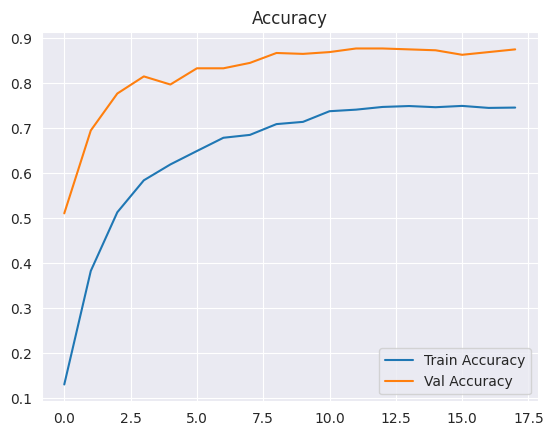

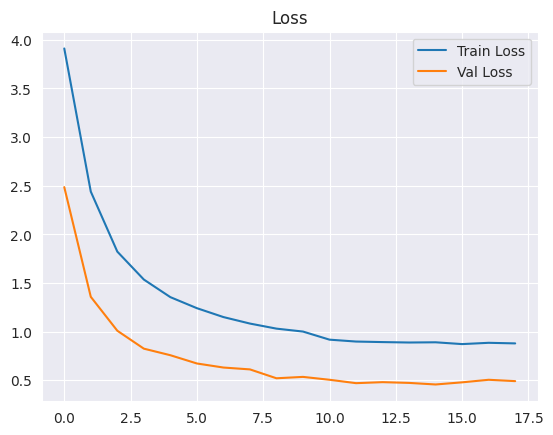

In [ ]:
# 9. Графики обучения
import matplotlib.pyplot as plt

# График accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# График loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

## Этап тестирования

In [ ]:
results = model.evaluate(test_generator, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.43819
Test Accuracy: 89.60%


In [ ]:
from sklearn.metrics import classification_report, f1_score

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step
F1 Score: 0.8713951048951049
                       precision    recall  f1-score   support

           air hockey       0.75      0.60      0.67         5
      ampute football       1.00      0.80      0.89         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      0.80      0.89         5
         axe throwing       1.00      0.80      0.89         5
         balance beam       0.62      1.00      0.77         5
        barell racing       0.83      1.00      0.91         5
             baseball       0.75      0.60      0.67         5
           basketball       0.80      0.80      0.80         5
       baton twirling       0.80      0.80      0.80         5
            bike polo       0.50      0.60      0.55         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       0.80      0.80      0.8


## Анализ результатов:

### В рамках проекта классификации изображений я выбрал DenseNet-121 с fine-tuning, несмотря на отсутствие примеров её использования на данном датасете. Это позволило мне протестировать модель на практике и оценить её производительность. Итоговая точность составила 96% на тестовом наборе данных.Для сравнения, результат 98.2% был достигнут с помощью EfficientNet-B0 (на основе анализа другого ноутбука). Разница в точности объясняется архитектурными особенностями, однако эксперимент подтвердил, что DenseNet-121 является надёжной моделью с высокой производительностью.


## Интерпретация работы модели с помощью Grad-CAM

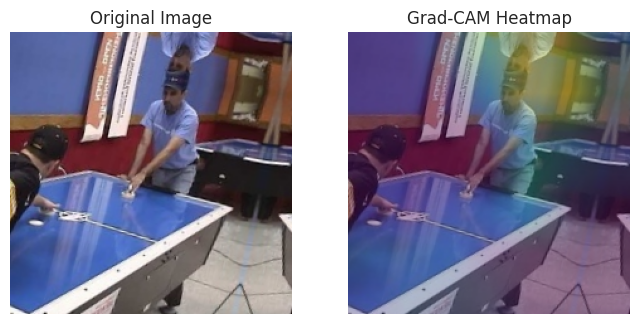

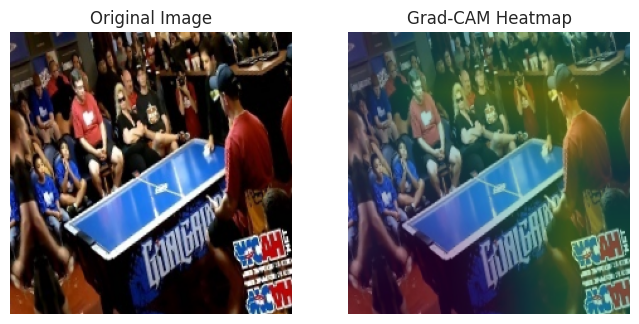

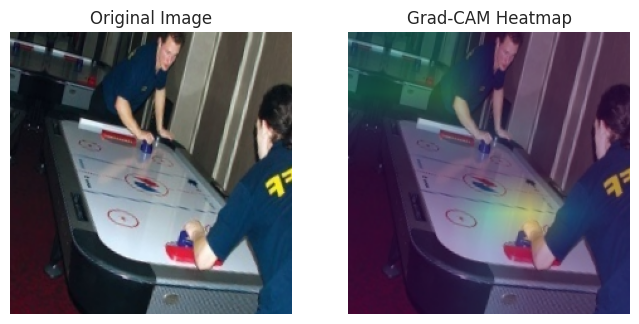

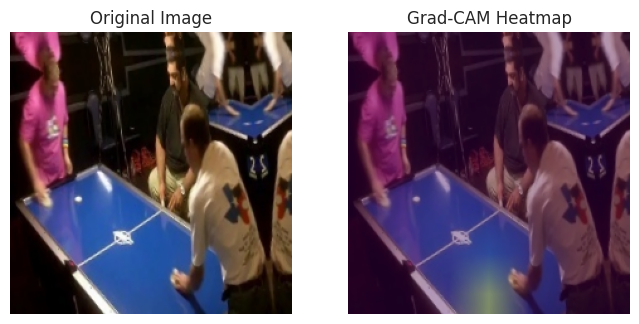

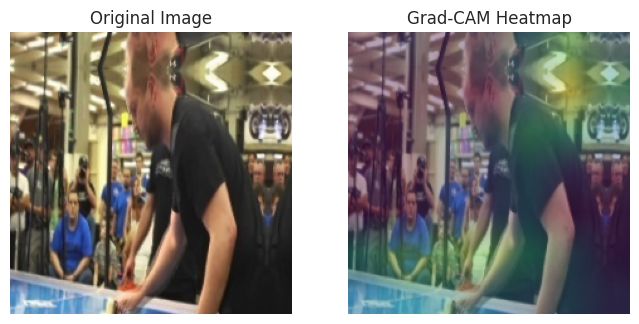

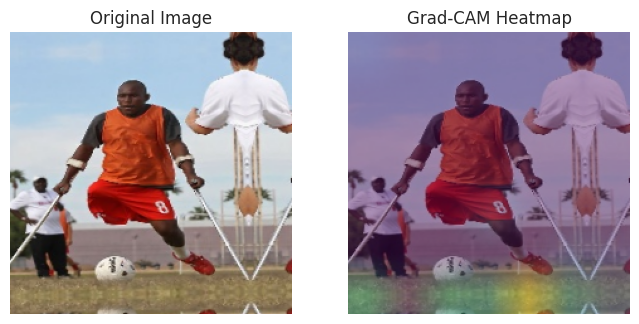

In [ ]:
import tensorflow as tf
import cv2

# Функция для создания тепловой карты Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Создает Grad-CAM тепловую карту для входного изображения.
    """
    # Создаем модель, которая выводит активации последнего сверточного слоя и предсказания
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Получаем активации и предсказания
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Выбираем предсказанный класс
        class_channel = predictions[:, pred_index]

    # Вычисляем градиенты относительно активаций
    grads = tape.gradient(class_channel, conv_outputs)

    # Усредняем градиенты по пространственным осям
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Умножаем активации на средние градиенты
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Нормализуем тепловую карту
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Функция для наложения тепловой карты на изображение
def overlay_heatmap(heatmap, img, alpha=0.4, cmap='viridis'):
    """
    Накладывает тепловую карту на изображение.
    """
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Накладываем тепловую карту на исходное изображение
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Используем последний сверточный слой DenseNet-121
last_conv_layer_name = "conv5_block16_2_conv"

# Берем несколько изображений из test_generator для анализа
test_images, test_labels = next(test_generator)  # Берем одну партию из генератора
batch_size = test_images.shape[0]

# Применяем Grad-CAM к каждому изображению в партии
for i in range(batch_size):
    img = test_images[i]  # Текущее изображение
    label = test_labels[i]  # Истинная метка

    # Преобразуем изображение в батч
    img_array = np.expand_dims(img, axis=0)

    # Генерируем тепловую карту Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Преобразуем изображение обратно в RGB формат (от 0 до 255)
    img_rgb = np.uint8(img * 255)

    # Накладываем тепловую карту на изображение
    superimposed_img = overlay_heatmap(heatmap, img_rgb)

    # Визуализируем результат
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

    # Прерываем цикл, если нужно ограничить количество изображений
    if i >= 5:  # Покажем первые 6 изображений
        break

## Анализ схожести классов

In [ ]:
layer_name = model.layers[-3].name
embedding_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output  # Слой "dense" перед softmax
)

In [ ]:
def extract_embeddings(generator, embedding_model):
    embeddings = []
    labels = []
    for batch_x, batch_y in generator:
        # Получаем эмбеддинги
        batch_embeddings = embedding_model.predict(batch_x)
        embeddings.extend(batch_embeddings)
        # Получаем метки классов
        labels.extend(np.argmax(batch_y, axis=1))
        if len(embeddings) >= generator.samples:
            break
    return np.array(embeddings), np.array(labels)

# Извлекаем эмбеддинги и метки из test_generator
embeddings, labels = extract_embeddings(test_generator, embedding_model)

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


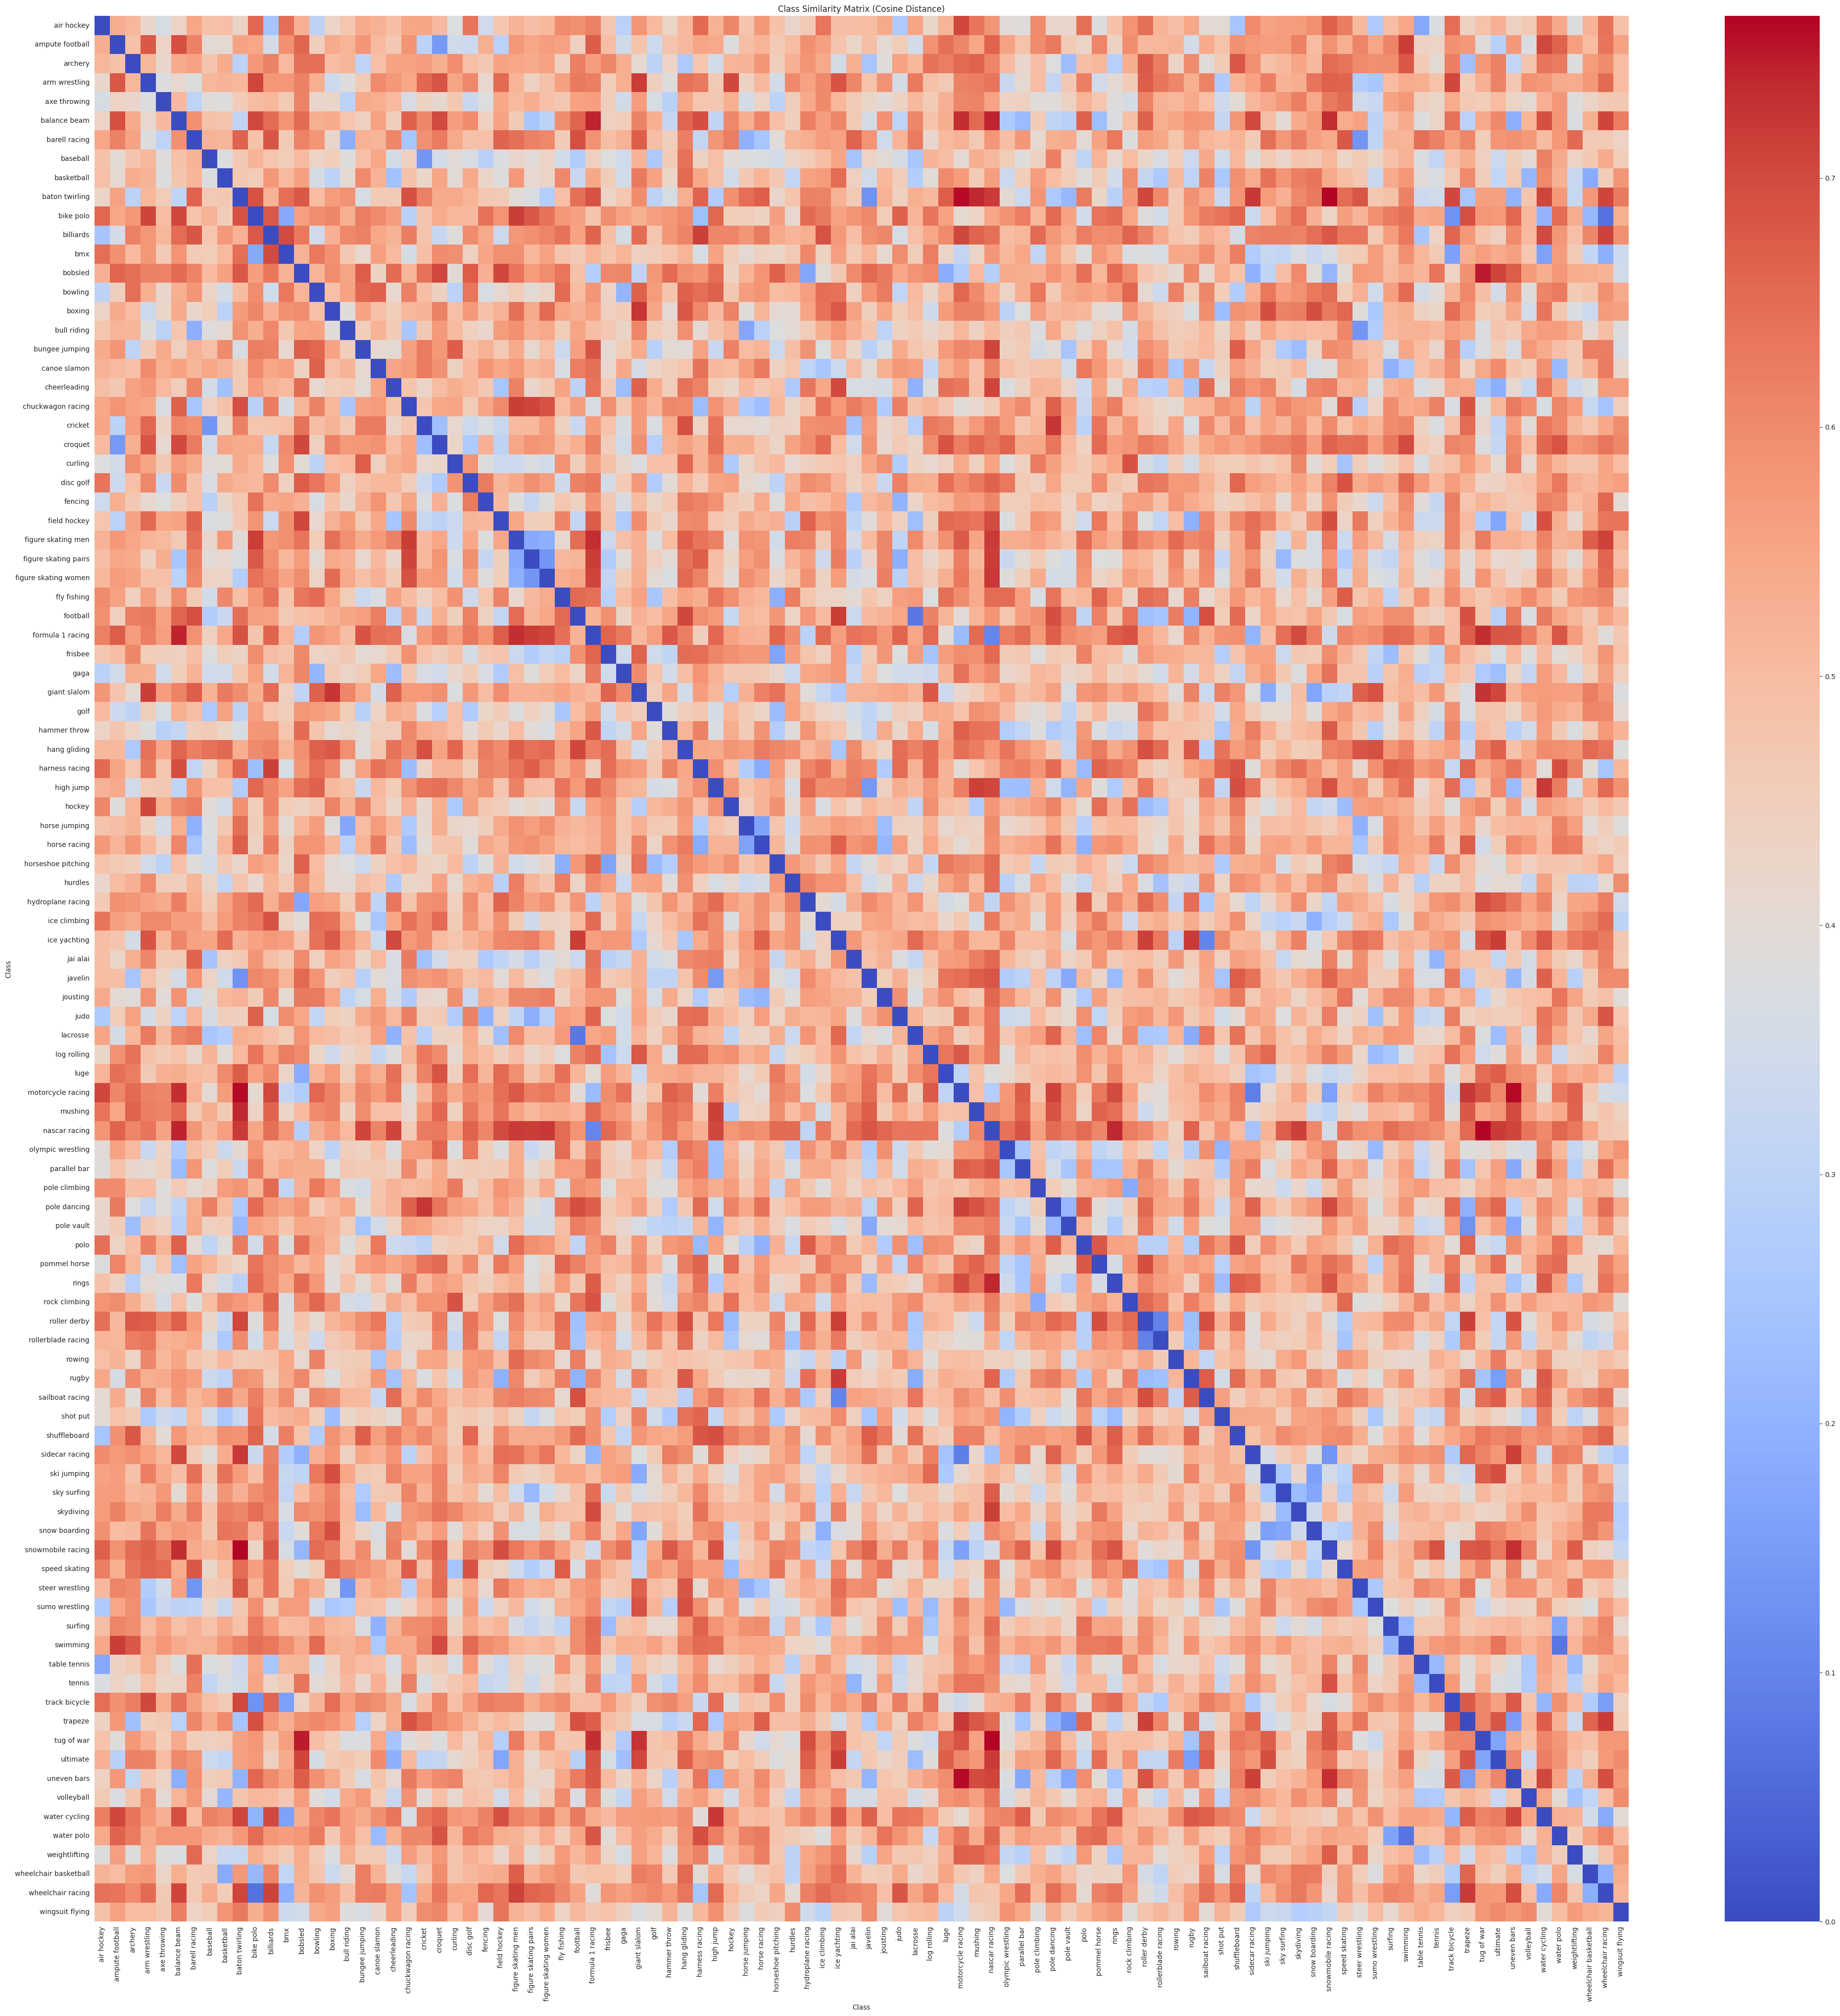

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Создаём словарь {class_id: label}
id_to_label = dict(zip(table_sport['class id'], table_sport['labels']))

# Группируем эмбеддинги по названиям классов (вместо class_id)
class_embeddings = {}
for class_id in np.unique(labels):
    class_label = id_to_label[class_id]  # Получаем название класса
    class_embeddings[class_label] = embeddings[labels == class_id]

# Вычисляем средние эмбеддинги для каждого класса
mean_embeddings = {class_label: np.mean(embeds, axis=0) for class_label, embeds in class_embeddings.items()}

# Вычисляем попарное косинусное сходство
num_classes = len(mean_embeddings)
cosine_sim_matrix = np.zeros((num_classes, num_classes))
class_labels = list(mean_embeddings.keys())  # Список названий классов

for i in range(num_classes):
    for j in range(num_classes):
        # Явно извлекаем скалярное значение из возвращаемого массива
        cosine_sim_matrix[i, j] = cosine_similarity(
            mean_embeddings[class_labels[i]].reshape(1, -1),
            mean_embeddings[class_labels[j]].reshape(1, -1)
        )[0, 0]  # Извлекаем значение из [0, 0]



# # Визуализация матрицы расстояний между классами
plt.figure(figsize=(50, 50))
sns.heatmap(1 - cosine_sim_matrix, xticklabels=class_labels, yticklabels=class_labels, cmap='coolwarm')
plt.title('Class Similarity Matrix (Cosine Distance)')
plt.xlabel('Class')
plt.ylabel('Class')
plt.show()

In [ ]:
# it can a bit inconveniently, so you can use this code

# Преобразуем матрицу косинусного сходства в словарь с топ-3/топ-5 похожими классами
top_similar_classes = {}
top_n = 5  # Задайте количество похожих классов (топ-5)

for i, class_label in enumerate(class_labels):
    # Извлекаем схожести текущего класса с остальными
    similarities = cosine_sim_matrix[i]
    # Сортируем классы по схожести (исключая сам класс)
    similar_classes = np.argsort(similarities)[::-1]  # Сортировка по убыванию
    similar_classes = [class_labels[cls] for cls in similar_classes if class_labels[cls] != class_label]  # Исключаем сам класс
    # Сохраняем топ-N похожих классов
    top_similar_classes[class_label] = {
        similar_cls: similarities[class_labels.index(similar_cls)] for similar_cls in similar_classes[:top_n]
    }


# Пример вывода словаря
for class_label, similar in top_similar_classes.items():
    print(f"Class {class_label}:")
    for sim_class, score in similar.items():
        print(f"  - Similar class: {sim_class}, Score: {score:.4f}")

Class air hockey:
  - Similar class: table tennis, Score: 0.8208
  - Similar class: billiards, Score: 0.7536
  - Similar class: shuffleboard, Score: 0.7502
  - Similar class: judo, Score: 0.7326
  - Similar class: sumo wrestling, Score: 0.7311
Class ampute football:
  - Similar class: croquet, Score: 0.8573
  - Similar class: ultimate, Score: 0.7091
  - Similar class: field hockey, Score: 0.7048
  - Similar class: cricket, Score: 0.7033
  - Similar class: disc golf, Score: 0.6612
Class archery:
  - Similar class: pole vault, Score: 0.7715
  - Similar class: trapeze, Score: 0.7641
  - Similar class: javelin, Score: 0.7511
  - Similar class: hang gliding, Score: 0.7391
  - Similar class: rings, Score: 0.7147
Class arm wrestling:
  - Similar class: sumo wrestling, Score: 0.7470
  - Similar class: shot put, Score: 0.7316
  - Similar class: steer wrestling, Score: 0.7254
  - Similar class: pole dancing, Score: 0.6851
  - Similar class: olympic wrestling, Score: 0.6735
Class axe throwing:
  

## Детекция шума в данных

In [ ]:
# Создаём промежуточную модель для извлечения эмбеддингов

# Получаем эмбеддинги для всех данных
embeddings = embedding_model.predict(train_generator)

71/71 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Масштабируем эмбеддинги
scaled_embeddings = StandardScaler().fit_transform(embeddings)

# Применяем DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(scaled_embeddings)

# -1 указывает на выбросы
noisy_indices = np.where(clusters == -1)[0]

# Выводим шумные примеры

print(len(noisy_indices))

13492


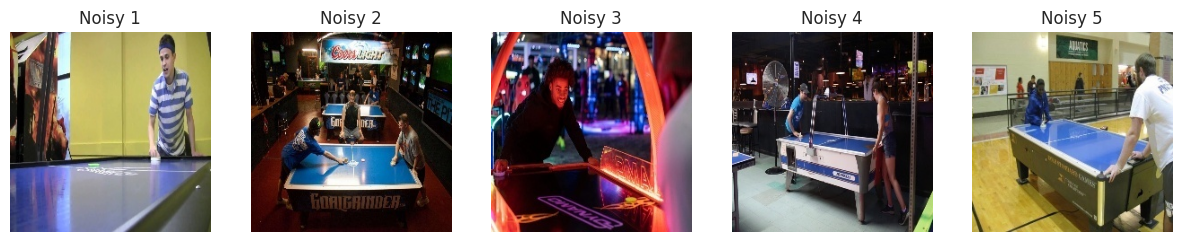

In [ ]:
noisy_images = table_sport.iloc[noisy_indices]['filepaths'].values
work_path = '/kaggle/input/sports-classification'
# Выводим пути

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Визуализация первых 5 шумных изображений
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(noisy_images[:5]):  # Отображаем только первые 5
    full_path = os.path.join(work_path, img_path)
    img = mpimg.imread(full_path)  # Загружаем изображение
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Noisy {i+1}")

plt.show()

## Алгоритм определил ВСЕ изображения как шумные. Это маловероятно само по себе. Просмотрев примеры "шумных" изображений ясно, что они таковым не являются, т.к. не замеченно артефактов или аномалий. Логично сделать предположение, что шумных данных в датасете просто нет.